### LSTM

In [32]:
token = 'INTC'
token_indicators = f'{token}-INDICATORS.csv'

### Get data

In [33]:
import pandas as pd
import numpy as np
data = pd.read_csv(f'../data/{token_indicators}', parse_dates=['Date'], index_col=['Date'])
data

,Close,High,Low,Open,Volume,ema20,ema50,rsi10,rsi30,macd,signal,hist,Price-Up
Date,,,,,,,,,,,,,
1980-05-27,0.190212,0.193116,0.190212,0.190938,8332800,0.185166,0.181155,60.595713,57.748655,0.003743,0.003599,0.000144,1
1980-05-28,0.194567,0.197472,0.194567,0.194567,6700800,0.186061,0.181681,66.976114,60.569530,0.004027,0.003685,0.000342,0
1980-05-29,0.194567,0.197472,0.194567,0.194567,7660800,0.186871,0.182186,66.976114,60.569530,0.004204,0.003789,0.000415,1
1980-05-30,0.197472,0.200376,0.197472,0.197472,5721600,0.187881,0.182785,70.860319,62.362640,0.004526,0.003936,0.000590,1
1980-06-02,0.198198,0.201102,0.198198,0.198198,6355200,0.188863,0.183390,71.782039,62.800044,0.004785,0.004106,0.000679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-18,23.660000,24.900000,23.209999,24.000000,212515600,21.868025,21.684996,65.022168,56.250773,0.348019,-0.121289,0.469308,1
2025-08-19,25.309999,26.530001,24.940001,24.940001,297659200,22.195832,21.827153,72.658591,60.333936,0.574202,0.017809,0.556393,0
2025-08-20,23.540001,24.930000,23.330000,24.900000,161149400,22.323848,21.894324,57.655400,54.671543,0.603670,0.134981,0.468689,0


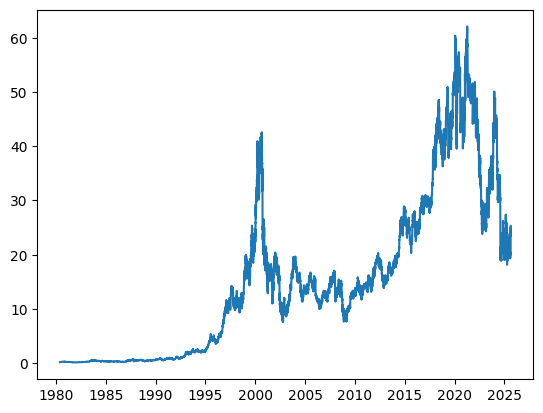

In [34]:
import matplotlib.pyplot as plt
plt.plot( data['Close'])

#### Split features and target

In [35]:
features = ['Close', 'High', 'Low', 'Open', 'Volume', 'ema20', 'ema50', 'rsi10', 'rsi30', 'macd', 'signal', 'hist']
target = ['Price-Up']
# Separar X e y
X = data[features]
y = data[target].to_numpy()
X.shape, y.shape


((11404, 12), (11404, 1))

#### Split dataset

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10263, 12), (1141, 12), (10263, 1), (1141, 1))

### Scale data

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape

((10263, 12), (1141, 12))

#### Sliding Window

In [25]:
sequence_length = 30 
X_train_sequences = []
y_train_sequences = []
X_test_sequences = []
y_test_sequences = []
for i in range(sequence_length, len(X_train)): 
    X_train_sequences.append(X_train_scaled[i - sequence_length: i])
    y_train_sequences.append(y_train[i])

for i in range(sequence_length, len(X_test)): 
    X_test_sequences.append(X_test_scaled[i - sequence_length: i])
    y_test_sequences.append(y_test[i])

X_train_sequences = np.array(X_train_sequences)
y_train_sequences = np.array(y_train_sequences)
X_test_sequences = np.array(X_test_sequences)
y_test_sequences = np.array(y_test_sequences)
X_train_sequences.shape, y_train_sequences.shape, X_test_sequences.shape, y_test_sequences.shape
#Aca optenemos la (cantidad de secuencias(ventanas), cantidad de dias, cantidad de features)

((10233, 30, 12), (10233, 1), (1111, 30, 12), (1111, 1))

### Pytorch Implementation

In [26]:
# Convertimos los datos a tensores 
import torch
X_train_tensor = torch.tensor(X_train_sequences, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_sequences, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_sequences, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_sequences, dtype=torch.float32)

X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape 

(torch.Size([10233, 30, 12]),
 torch.Size([1111, 30, 12]),
 torch.Size([10233, 1]),
 torch.Size([1111, 1]))

#### Architecture 

In [27]:
import torch
import torch.nn as nn
# Creamos la clase o sub-clase de nn.Module 
# Creamos dos metodos init y forward

class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        # Definimos una capa LSTM y un full connected layer

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

        
    def forward(self, x):
        # Inicializamos los vectores de estado oculto y de celda con ceros 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:,-1,:] 
        out = self.fc(out) 
        return out

In [28]:
# Cada instanacia lo movemos a la gpu
import torch

# Parameters of the model 
input_size = X_train_tensor.shape[2]  # 12
hidden_size = 64
num_layers  = 2
output_size = 1 # Classification 


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = MyLSTM(input_size, hidden_size, num_layers, output_size).to(device)
print(model)



Using device: cpu
MyLSTM(
  (lstm): LSTM(12, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


#### Dataset and Dataloader

In [29]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor) # Instanciamos la clase  
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size, shuffle=True) # Instanciamos la clase DataLoader
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print(len(train_loader))
for batch_X, batch_y in train_loader:
    print("Batch X shape:", batch_X.shape)
    print("Batch y shape:", batch_y.shape)
    # Solo el primer batch
    break


320
Batch X shape: torch.Size([32, 30, 12])
Batch y shape: torch.Size([32, 1])


#### Training Loop

In [20]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training
num_epochs = 150 
model.train()
print(f'Training on {device}')

for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device) #[32, 30, 8]
        batch_y = batch_y.to(device) #[32, 1]
        # Forward pass
        outputs = model(batch_X).squeeze() # [batch_size, 1] => [batch_size] 

        loss = criterion(outputs, batch_y.squeeze())

        # Backward pass
        loss.backward()

        optimizer.step()

        optimizer.zero_grad()
    if (epoch + 1 ) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')





Training on cuda
Epoch [10/150], Loss: 0.6850
Epoch [20/150], Loss: 0.6824
Epoch [30/150], Loss: 0.7006
Epoch [40/150], Loss: 0.7075
Epoch [50/150], Loss: 0.6550
Epoch [60/150], Loss: 0.6920
Epoch [70/150], Loss: 0.7061
Epoch [80/150], Loss: 0.6870
Epoch [90/150], Loss: 0.7103
Epoch [100/150], Loss: 0.6914
Epoch [110/150], Loss: 0.7845
Epoch [120/150], Loss: 0.6979
Epoch [130/150], Loss: 0.6614
Epoch [140/150], Loss: 0.6772
Epoch [150/150], Loss: 0.7396


In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix
import torch
import numpy as np

model.eval()  # Modo de evaluación

y_true = []  # Etiquetas reales
y_pred = []  # Predicciones binarias
y_probs = []  # Probabilidades predichas

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        # Forward pass
        outputs = model(batch_X).squeeze()   # Logits
        probs = torch.sigmoid(outputs)       # Probabilidades
        predicted = torch.round(probs)       # Predicciones binarias (0 o 1)

        # Guardar los valores reales y predichos
        y_true.extend(batch_y.view(-1).cpu().numpy())  # Solución aquí ✅
        y_pred.extend(predicted.view(-1).cpu().numpy())
        y_probs.extend(probs.view(-1).cpu().numpy())

# Convertir listas a numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)

# Calcular métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_probs)
report = classification_report(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

# Mostrar resultados
print(f'Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'ROC-AUC: {roc_auc:.2f}')
print(report)
print(conf_matrix)



Accuracy: 0.49%
Precision: 0.48
Recall: 0.74
F1-Score: 0.58
ROC-AUC: 0.52
              precision    recall  f1-score   support

         0.0       0.50      0.25      0.34       571
         1.0       0.48      0.74      0.58       540

    accuracy                           0.49      1111
   macro avg       0.49      0.49      0.46      1111
weighted avg       0.49      0.49      0.46      1111

[[144 427]
 [142 398]]


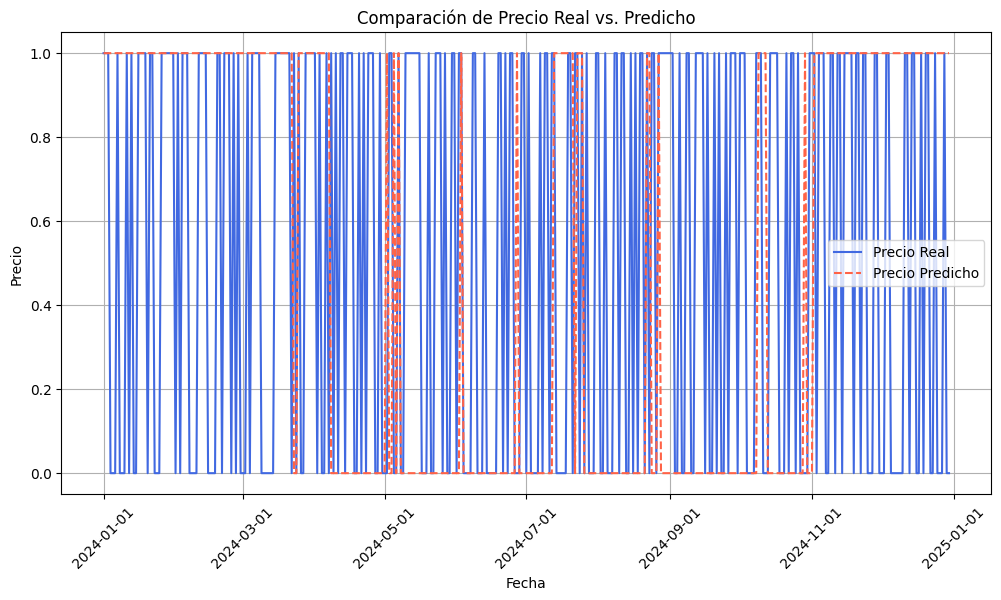

In [15]:
import matplotlib.dates as mdates 
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que tienes un DataFrame con fechas
fechas = pd.date_range(start="2024-01-01", periods=len(y_true), freq="D")

plt.figure(figsize=(12, 6))
plt.plot(fechas, y_true, label="Precio Real", color='royalblue')
plt.plot(fechas, y_pred, label="Precio Predicho", color='tomato', linestyle='dashed')

# Mejorar formato de fechas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formato Año-Mes-Día
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-ajuste de fechas

plt.xticks(rotation=45)  # Rotar etiquetas para mejor visibilidad
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.title("Comparación de Precio Real vs. Predicho")
plt.legend()
plt.grid(True)

plt.show()
